# Capstone Project
### DATA 606, Spring 2022, Dr. Chaojie Wang

#### Description: 
This notebook uses the ARIMA Machine Learning data to apply to the cleansed summary-level micromobility data generated in the EDA jupyter notebook.  This notebook will build the ARIMA model and attempt to use it to predict micromobility usage in the cities in our analysis.  

#### Dataset Sources:
<ul><li>New York City: <a href='https://ride.citibikenyc.com/system-data'>https://ride.citibikenyc.com/system-data</a> </li>
    <li>Chicago: <a href='https://ride.divvybikes.com/system-data'>https://ride.divvybikes.com/system-data</a> </li>
    <li>San Francisco: <a href='https://www.lyft.com/bikes/bay-wheels/system-data'>https://www.lyft.com/bikes/bay-wheels/system-data</a> </li>
</ul>

## Function Definitions & Setup
This section deals with imports and function definitions

In [2]:
import pandas as pd
pd.__version__

'1.3.4'

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import glob

In [6]:
import os
from os.path import join, isdir
from os import mkdir, path

In [7]:
import datetime

In [8]:
# Import my helper py file to help with importing the data
import dfimporthelpers as imp

In [12]:
# For ACF and PACF plots that are used in SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<br><br>

# Load the prepared micromobility data that is pre-grouped by date of each trip by city

In [63]:
dir_path = '/Users/DF/Library/CloudStorage/OneDrive-Personal/Documents/' + \
           'Grad School-David’s MacBook Pro/Spring 2022 - Capstone/JupyterNB/'

os.chdir(dir_path)

In [64]:
df = pd.read_csv('nyc_chicago_sf_tripsbymonth_jan19tojan22.csv', low_memory=False, dtype='unicode')

In [68]:
# Set field types
df['start_date'] = pd.to_datetime(df['year-month']) 
df['#trips'] = df['#trips'].astype(int)

In [69]:
# Fill nulls in #Trips with 0
df[['#trips']] = df[['#trips']].fillna(value=0)

In [70]:
# Set the start_date as the dataframe's index
df.set_index('start_date', inplace=True)

<br />

### View the data

In [71]:
df.head()

,year-month,city,#trips,month_date
start_date,,,,
2019-01-01,2019-01,Chicago,103272,2019-01-01
2019-01-01,2019-01,NYC,967287,2019-01-01
2019-01-01,2019-01,San Francisco,192082,2019-01-01
2019-02-01,2019-02,Chicago,96186,2019-02-01
2019-02-01,2019-02,NYC,943744,2019-02-01


In [72]:
df.dtypes

year-month            object
city                  object
#trips                 int64
month_date    datetime64[ns]
dtype: object

<br />

### Plot by Date

In [73]:
# Pivot to prepare to plot the years and cities
df_pivot = df.pivot(columns='city', values='#trips')

In [74]:
df_pivot.head()

city,Chicago,NYC,San Francisco
start_date,,,
2019-01-01,103272,967287,192082
2019-02-01,96186,943744,183412
2019-03-01,165611,1327960,256299
2019-04-01,265310,1766094,239111
2019-05-01,367458,1924563,182163


<Figure size 432x288 with 0 Axes>

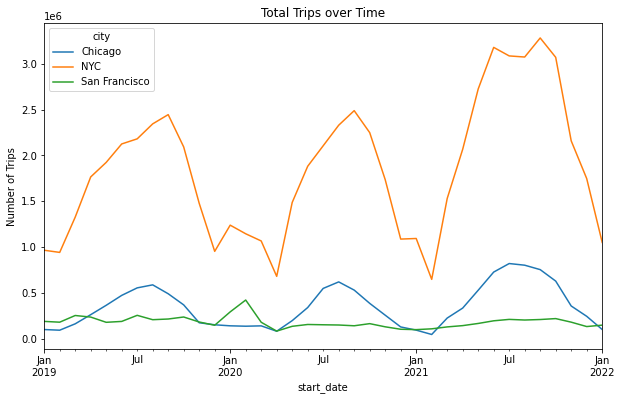

In [76]:
heading = 'Total Trips over Time'

plt.figure()
ax = df_pivot.plot.line(stacked=False, figsize=(10,6), title=heading)
ax.set_ylabel('Number of Trips')
    
# Display to screen
plt.show()

### First we'll analyze Chicago

In [85]:
df_chicago = df[(df['city'] == 'Chicago') & (df['year-month'] < '2022-01')]

<br />

### Determine Parameters for the SARIMA Model
##### Reference Source: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c

SARIMA(p,d,q)(P,D,Q)m

<ul>
    <li>p: order of the AR part</li>
    <li>d: degree of first differencing involved</li>
    <li>q: order of the moving average part</li>
    <li>P: Seasonal autoregressive order</li>
    <li>D: Seasonal difference order</li>
    <li>Q: Seasonal moving average order</li>
    <li>m: The number of time steps for a single seasonal period</li>
</ul>

In [94]:
df_chicago.head(5)

,year-month,city,#trips,month_date
start_date,,,,
2019-01-01,2019-01,Chicago,103272,2019-01-01
2019-02-01,2019-02,Chicago,96186,2019-02-01
2019-03-01,2019-03,Chicago,165611,2019-03-01
2019-04-01,2019-04,Chicago,265310,2019-04-01
2019-05-01,2019-05,Chicago,367458,2019-05-01


### Determine Value of p by using an ACF plot. p corresponds to the maximum value in the ACF graph external to the confidence intervals 

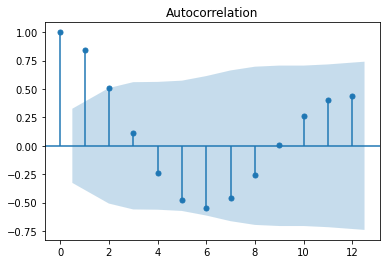

In [99]:
plot_acf(df_chicago['#trips'], lags=12)
plt.show()

#### Based on this, our p value is 2

### Determine Value of d by using the Dickey-Fuller test to determine Stationarity

#### Source of function used: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c

We will use the Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary", 'p value = ', pvalue)
        return True
    else:
        print("X is not stationary")
        return False

In [107]:
ts = df_chicago['#trips']

ts_diff = pd.Series(ts)
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is stationary p value =  5.941204732686406e-05


In [105]:
print('The value of d = ', d)

The value of d =  0


#### Based on this, our d value is 0

### Determine Value of q by using the PACF plot

/Users/DF/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


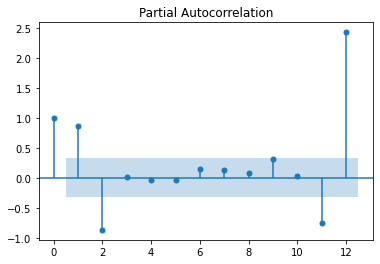

In [100]:
plot_pacf(df_chicago['#trips'], lags=12)
plt.show()

#### Based on this, our q value is 12 as it is the maximum value outside the confidence interval (blue shade)

### Train the Model
##### Source of Functions: https://towardsdatascience.com/how-to-model-a-time-series-through-a-sarima-model-e7587f85929c


In [134]:
ts = df_chicago['#trips']

train = ts.iloc[:-12]
test = ts.iloc[-12:]

In [135]:
print('All: ', ts.shape)
print('Train: ', train.shape)
print('Test: ', test.shape)

All:  (36,)
Train:  (24,)
Test:  (12,)


In [136]:

from statsmodels.tsa.statespace.sarimax import SARIMAX



# Use our parameter values as determined above
p = 2
d = 0
q = 12

model = SARIMAX(train, order=(p,d,q))
model_fit = model.fit(disp=1,solver='powell')
    
fcast = model_fit.get_prediction(start=1, end=len(ts))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()


/Users/DF/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/DF/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/DF/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57946D+01    |proj g|=  5.70425D+00

At iterate    1    f=  1.31280D+01    |proj g|=  2.89340D-01

At iterate    2    f=  1.30593D+01    |proj g|=  1.66744D-01

At iterate    3    f=  1.29865D+01    |proj g|=  5.85964D-02

At iterate    4    f=  1.29791D+01    |proj g|=  4.42043D-02

At iterate    5    f=  1.29732D+01    |proj g|=  1.93236D-02

At iterate    6    f=  1.29716D+01    |proj g|=  1.27503D-02

At iterate    7    f=  1.29712D+01    |proj g|=  8.90345D-03

At iterate    8    f=  1.29708D+01    |proj g|=  4.28131D-03

At iterate    9    f=  1.29707D+01    |proj g|=  2.53029D-03

At iterate   10    f=  1.29707D+01    |proj g|=  1.01986D-03

At iterate   11    f=  1.29707D+01    |proj g|=  7.83788D-04

At iterate   12    f=  1.29707D+01    |proj g|=  9.99393D-04

At iterate   13    f=  1.2

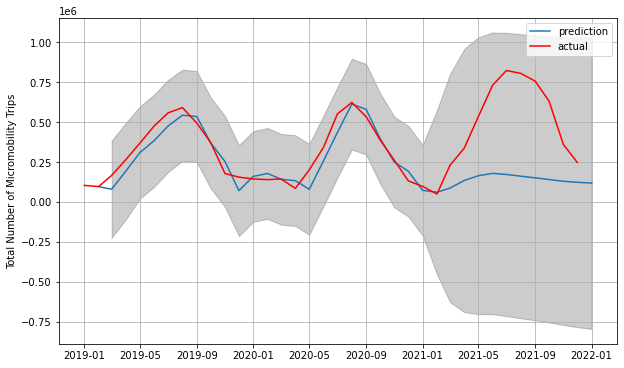

In [137]:
plt.figure(figsize=(10, 6))
plt.plot(ts_p,label='prediction')
plt.plot(ts,color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)
plt.ylabel('Total Number of Micromobility Trips')
plt.legend()
#plt.tight_layout()
plt.grid()
plt.show()

### Assess performance using the Root-Mean Squared metric
##### Based on: https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa



In [141]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(ts_p.iloc[-12:], test)/(np.max(test)-np.min(test))
nrmse

0.5344590038957264

In [139]:
df_chicago['#trips'].mean()

359854.1666666667